# RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\envs\morti_os_suite\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        # Grab a Random Starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create Batch time series on x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

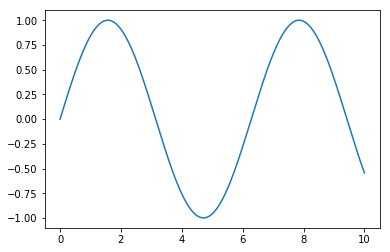

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

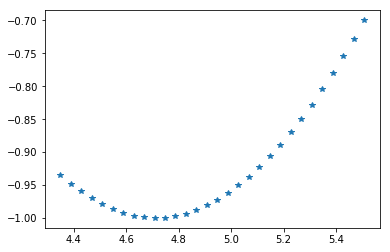

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

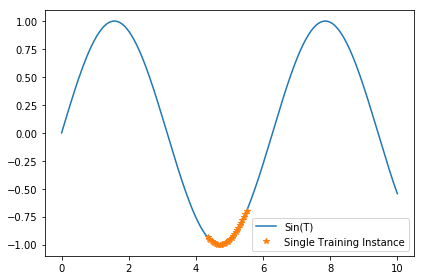

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(T)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label="Single Training Instance")
plt.legend()
plt.tight_layout()

In [9]:
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

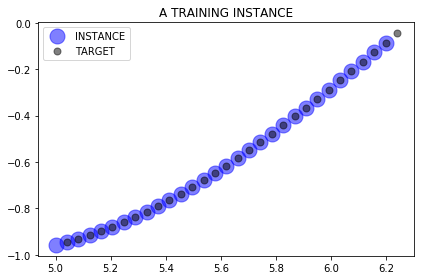

In [10]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize = 15,alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize = 7,alpha=0.5,label='TARGET')
plt.legend()
plt.tight_layout()

# Creating the Model

In [11]:
tf.reset_default_graph()

In [12]:
# Hyperparams
num_inputs = 1
num_neuron = 200
num_outputs = 1
learning_rate = 0.0001
num_training_iterations = 4000
batch_size = 1

In [13]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [14]:
# RNN CELL LAYER
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(
        num_units=num_neuron,activation=tf.nn.relu), 
    output_size=num_outputs)

Instructions for updating:
Use the retry module or similar alternatives.


In [15]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [16]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [18]:
train = optimizer.minimize(loss)

In [19]:
init = tf.global_variables_initializer()

In [20]:
#SESSION
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [21]:
saver = tf.train.Saver()

In [22]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    for interation in range(num_training_iterations):
        X_batch,y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        if interation % 100 ==0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(interation,"\tMSE",mse)
            
    saver.save(sess,"./rnn_time_series_model_codealong")

0 	MSE 0.22155723
100 	MSE 0.31965032
200 	MSE 0.04339751
300 	MSE 0.09731388
400 	MSE 0.045827415
500 	MSE 0.037107322
600 	MSE 0.063801676
700 	MSE 0.027247697
800 	MSE 0.0023185494
900 	MSE 0.0042390525
1000 	MSE 0.003903012
1100 	MSE 0.0046282345
1200 	MSE 0.006732172
1300 	MSE 0.00087343506
1400 	MSE 0.026715057
1500 	MSE 0.022079254
1600 	MSE 0.02044545
1700 	MSE 0.03350108
1800 	MSE 0.01698798
1900 	MSE 0.0036979762
2000 	MSE 0.01061367
2100 	MSE 0.021186931
2200 	MSE 0.010784612
2300 	MSE 0.0012756638
2400 	MSE 0.015481258
2500 	MSE 0.010041677
2600 	MSE 0.0017865744
2700 	MSE 0.009253553
2800 	MSE 0.01389611
2900 	MSE 0.016404198
3000 	MSE 0.0077673667
3100 	MSE 0.011633362
3200 	MSE 0.006022978
3300 	MSE 0.017050505
3400 	MSE 0.0005918406
3500 	MSE 0.010668066
3600 	MSE 0.010903906
3700 	MSE 0.0045243036
3800 	MSE 0.007922279
3900 	MSE 0.00046759064


In [23]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


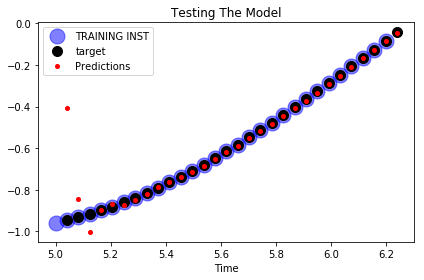

In [24]:
plt.title("Testing The Model")

# Training Instance
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="TRAINING INST")

# Target to Predict (Correct Test Values NP.SIN(TRAIN))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="target")

# MOdels Predictions
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=8,label="Predictions")

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# Generating new Sequences

In [25]:
with tf.Session() as sess:
        
    saver.restore(sess,"./rnn_time_series_model_codealong")
    
    #Seed Zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0,0.5,'Y')

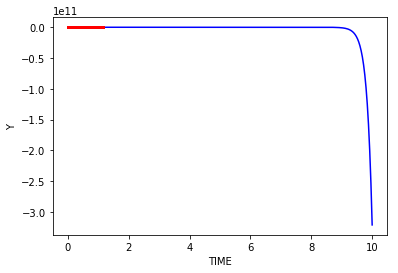

In [26]:
plt.plot(ts_data.x_data,zero_seq_seed,'-b')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel("Y")

In [27]:
with tf.Session() as sess:
        
    saver.restore(sess,"./rnn_time_series_model_codealong")
    
    #Seed Zeros
    training_instance = list(ts_data.x_data[:30])
    
    for iteration in range(len(training_instance)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0,0.5,'Y')

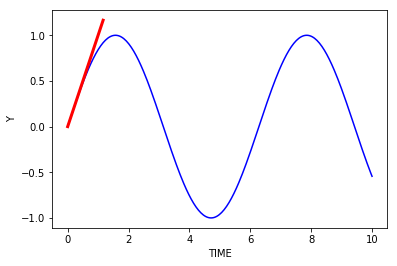

In [28]:
plt.plot(ts_data.x_data,ts_data.y_true,'-b')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel("Y")